In [1]:
HOME = "C:\\Users\\paslanpatir\\Documents\\GitHub\\fall21-yurdadonpelin\\"
setwd(HOME)

#Call necessary packages
options(warn = -1)
options(scipen=999)
require(data.table)
require(tidyverse)
require(ggplot2)
library(skimr)

library(kknn) # for task 1
library(glmnet) # for task2
library(flexclust) # for distance
#library(caret)

Loading required package: data.table

Loading required package: tidyverse

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x purrr::flatten()   masks jsonlite::flatten()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::transpose() masks data.table::transpose()

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-1

Loading required package: grid

Loading requ

# Task 3:

In [2]:
x_train = fread("./UWave/UWave/uWaveGestureLibrary_X_TRAIN.csv")
y_train = fread("./UWave/UWave/uWaveGestureLibrary_Y_TRAIN.csv")
z_train = fread("./UWave/UWave/uWaveGestureLibrary_Z_TRAIN.csv")

# add idx to the data sets
x_train[, idx := 1:.N]
y_train[, idx := 1:.N]
z_train[, idx := 1:.N]

# Calculate velocity and locations 
x_loc_train = copy(x_train)
y_loc_train = copy(y_train)
z_loc_train = copy(z_train)

# velocity
x_loc_train[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(x_loc_train),.SDcols = paste0("V",(2:316))]
y_loc_train[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(y_loc_train),.SDcols = paste0("V",(2:316))]
z_loc_train[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(z_loc_train),.SDcols = paste0("V",(2:316))]

# locations
x_loc_train[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(x_loc_train),.SDcols = paste0("V",(2:316))]
y_loc_train[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(y_loc_train),.SDcols = paste0("V",(2:316))]
z_loc_train[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(z_loc_train),.SDcols = paste0("V",(2:316))]

#####

x_test = fread("./UWave/UWave/uWaveGestureLibrary_X_TEST.csv")
y_test = fread("./UWave/UWave/uWaveGestureLibrary_Y_TEST.csv")
z_test = fread("./UWave/UWave/uWaveGestureLibrary_Z_TEST.csv")

# add idx to the data sets
x_test[, idx := 1:.N]
y_test[, idx := 1:.N]
z_test[, idx := 1:.N]

# Calculate velocity and locations 
x_loc_test = copy(x_test)
y_loc_test = copy(y_test)
z_loc_test = copy(z_test)

# velocity
x_loc_test[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(x_loc_test),.SDcols = paste0("V",(2:316))]
y_loc_test[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(y_loc_test),.SDcols = paste0("V",(2:316))]
z_loc_test[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(z_loc_test),.SDcols = paste0("V",(2:316))]

# locations
x_loc_test[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(x_loc_test),.SDcols = paste0("V",(2:316))]
y_loc_test[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(y_loc_test),.SDcols = paste0("V",(2:316))]
z_loc_test[, paste0("V",(2:316)) := as.list(cumsum(unlist(.SD))), 1:nrow(z_loc_test),.SDcols = paste0("V",(2:316))]

**Graphs**

V1,idx_ref
<dbl>,<int>
1,893
2,894
3,892
4,889
5,896
6,890
7,895
8,882


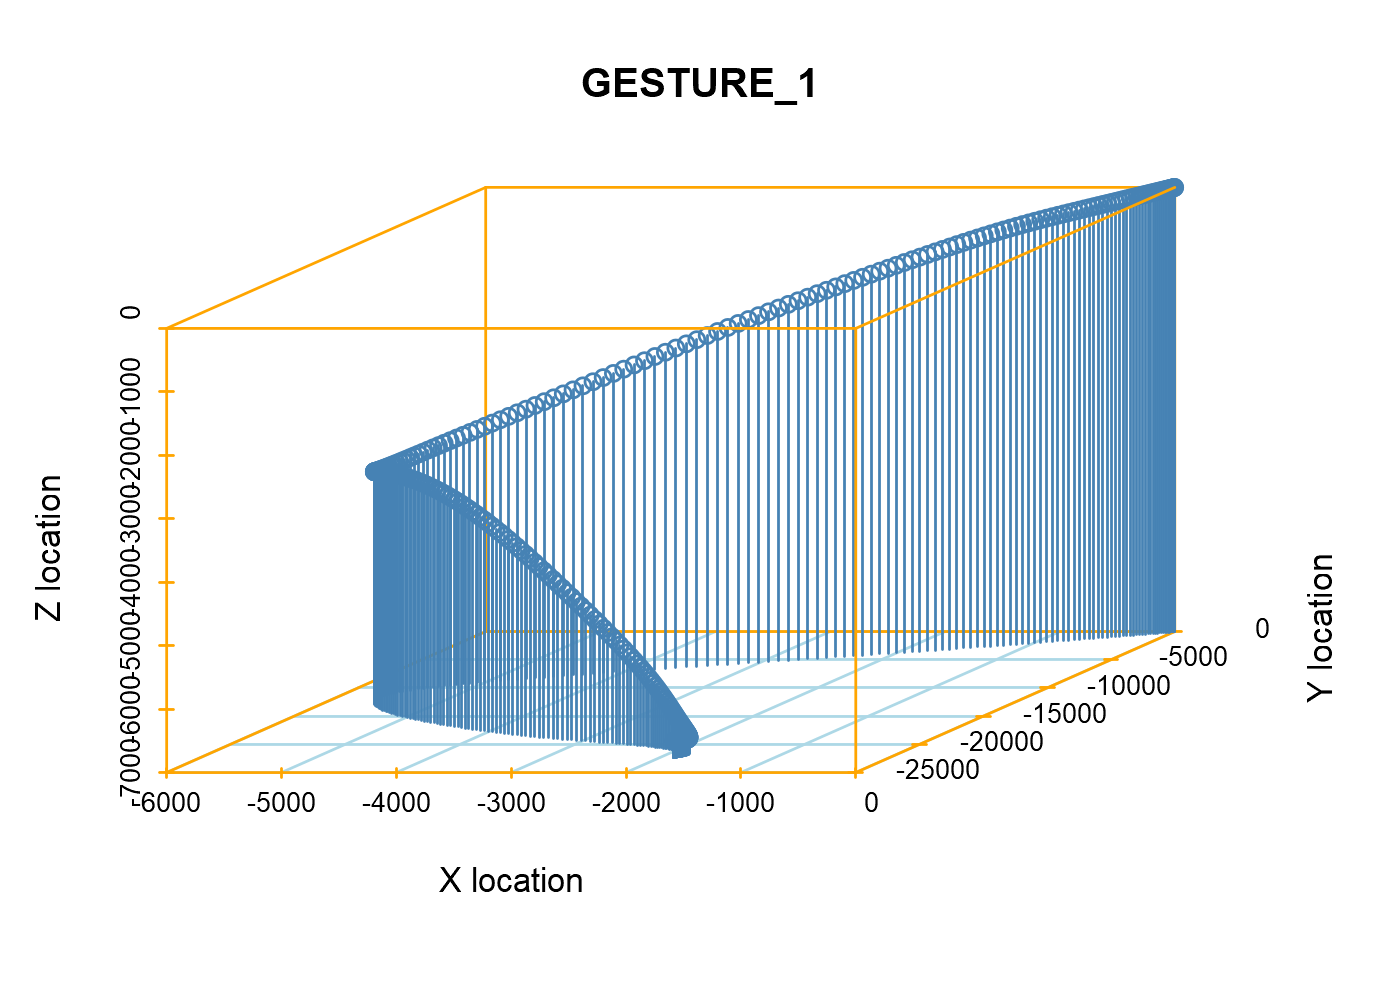

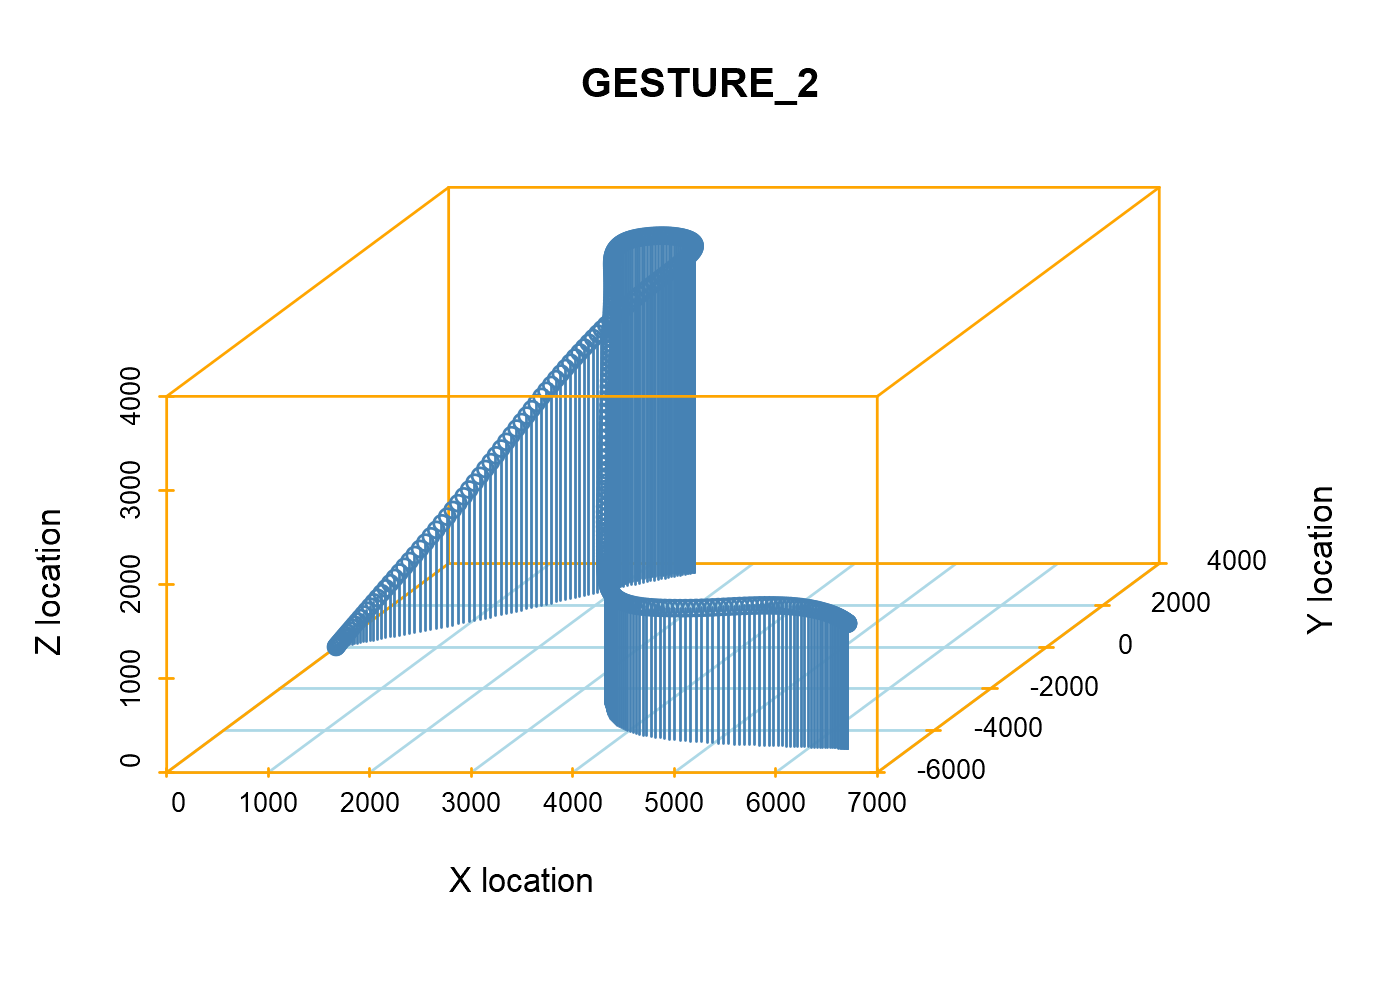

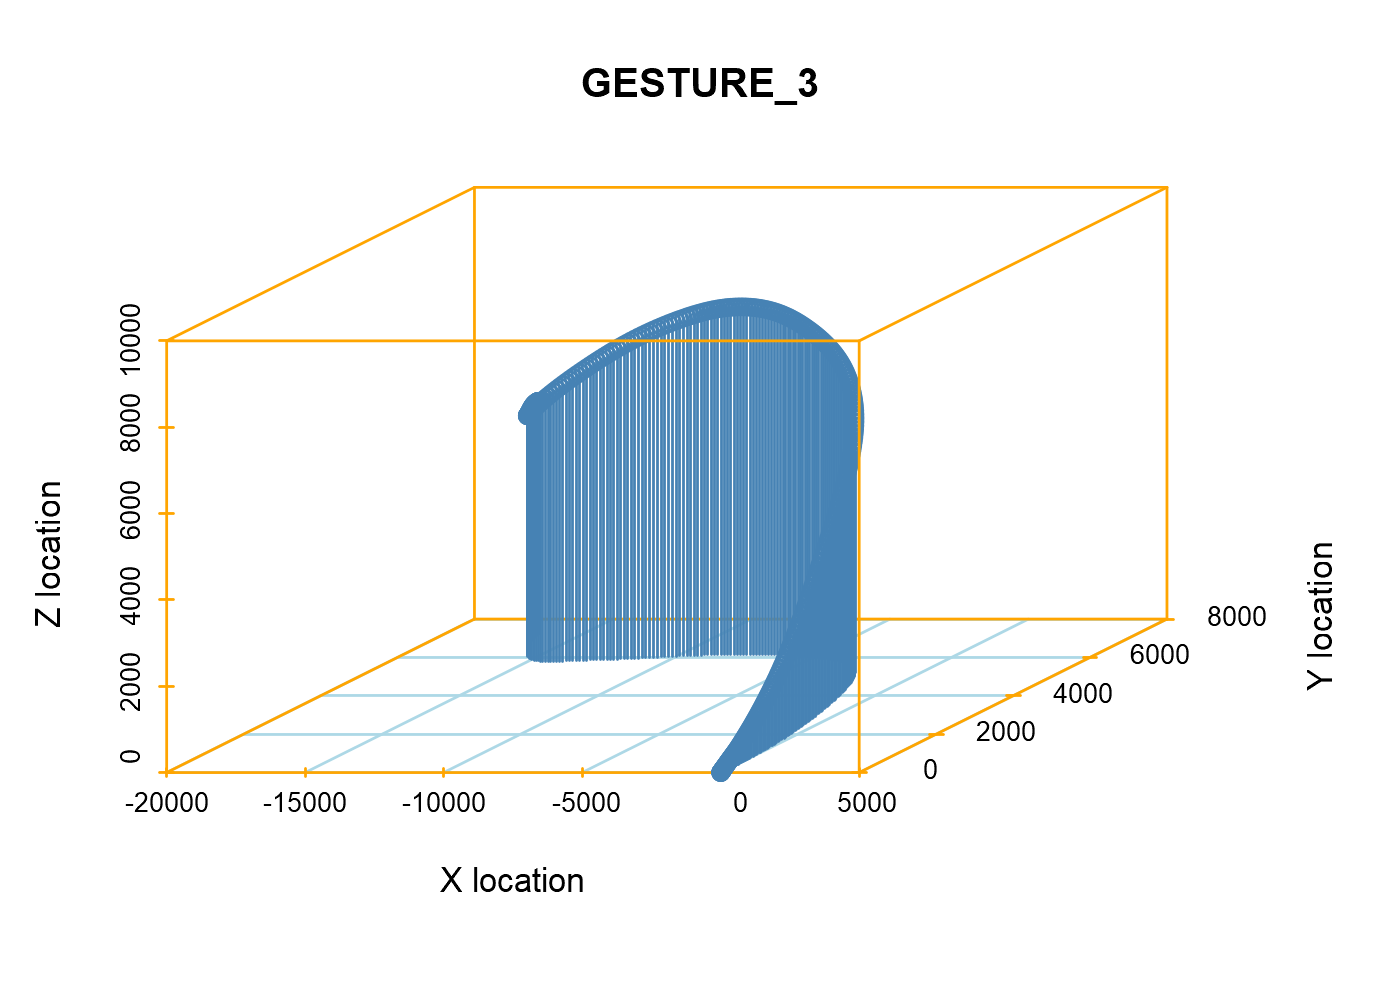

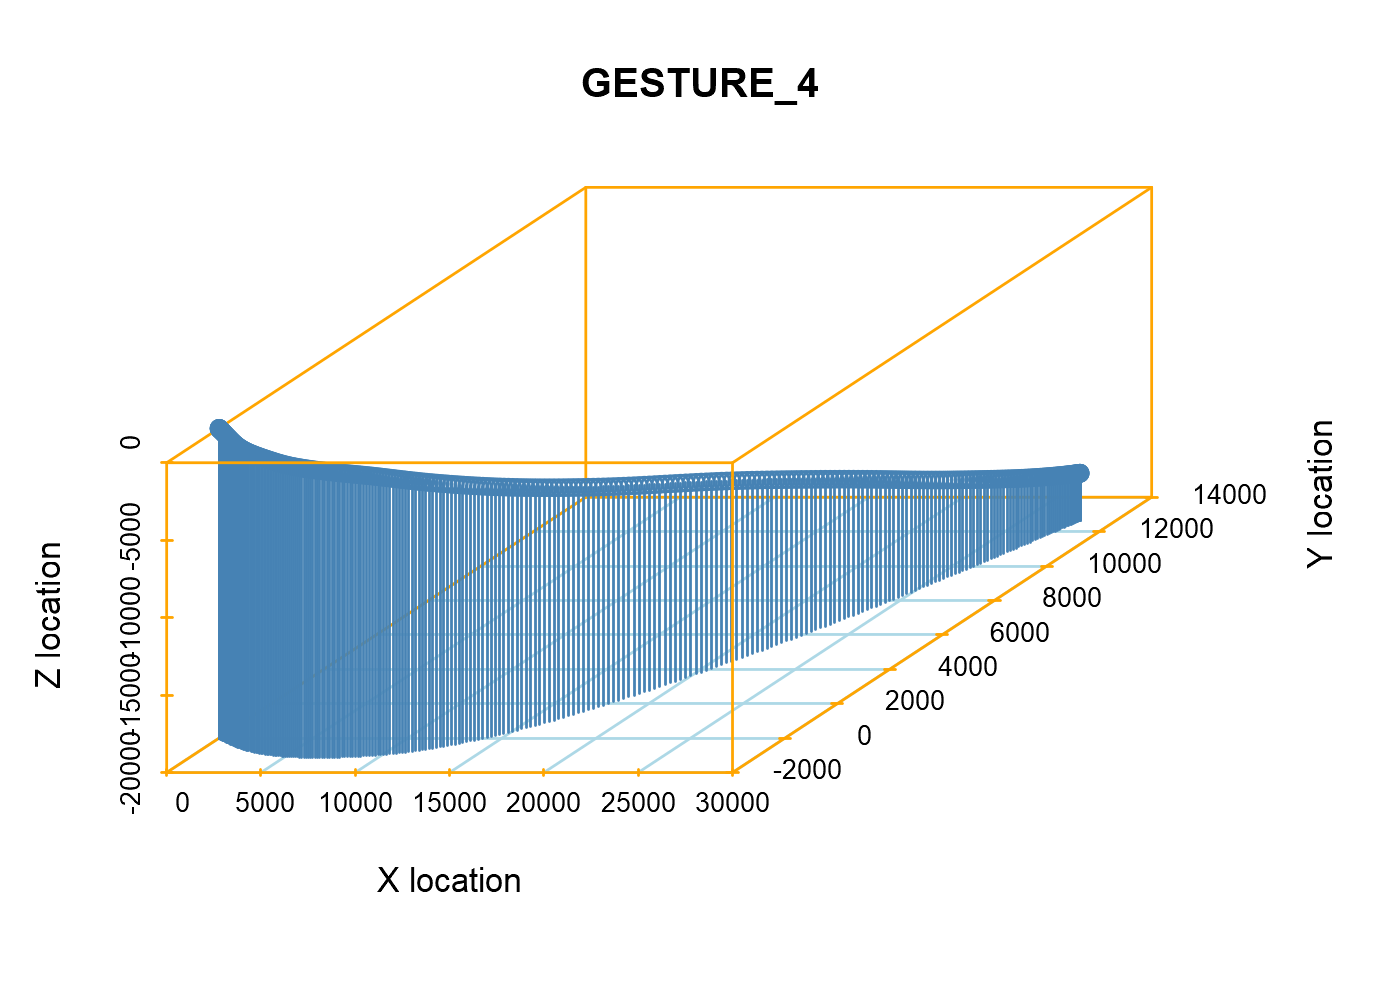

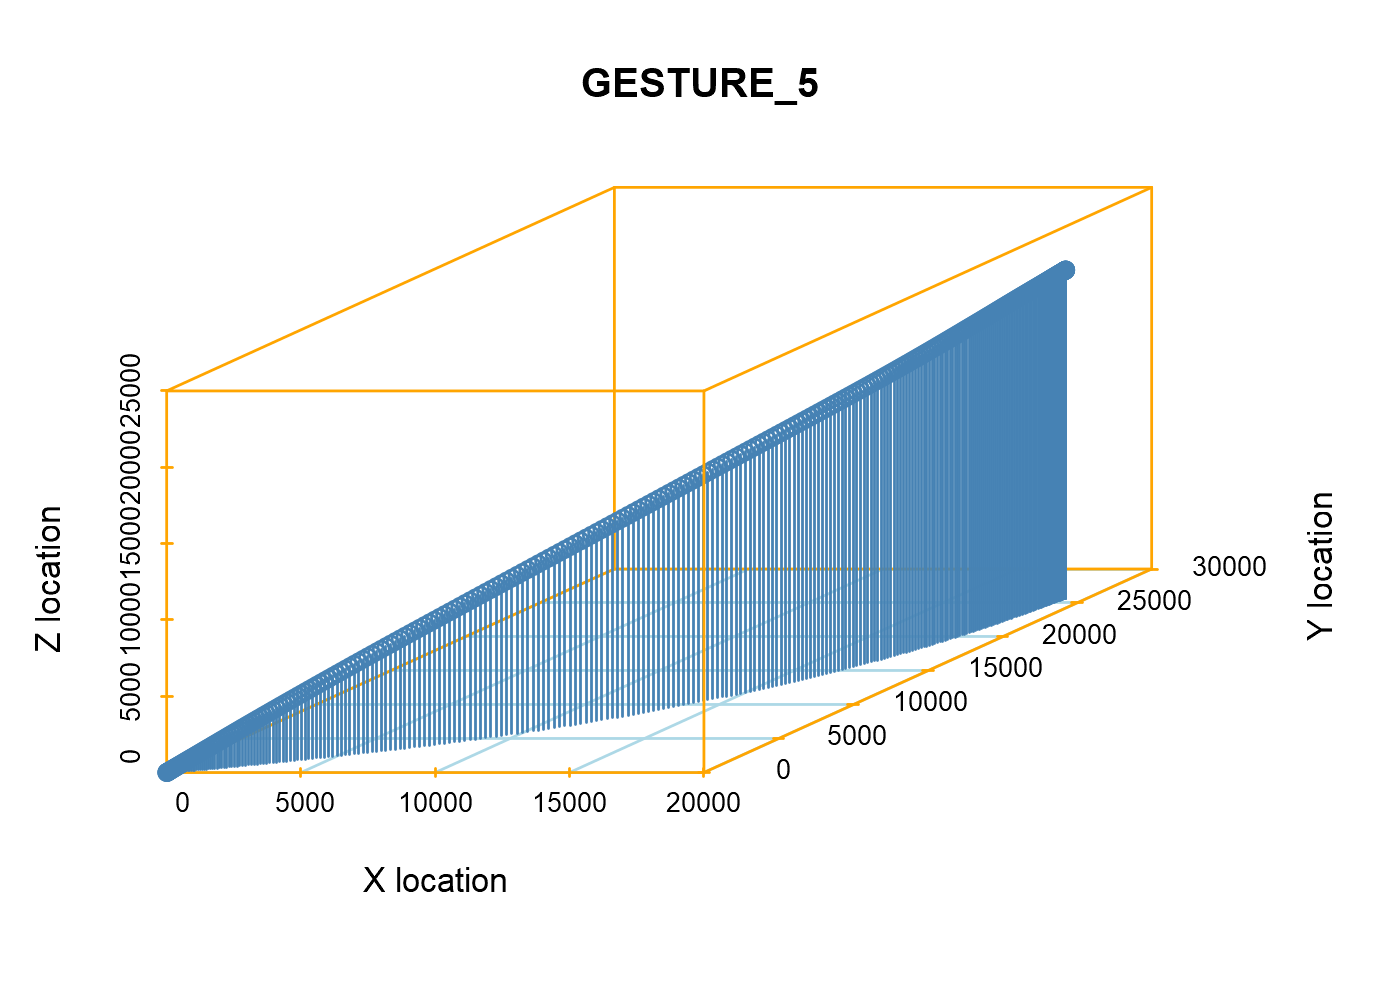

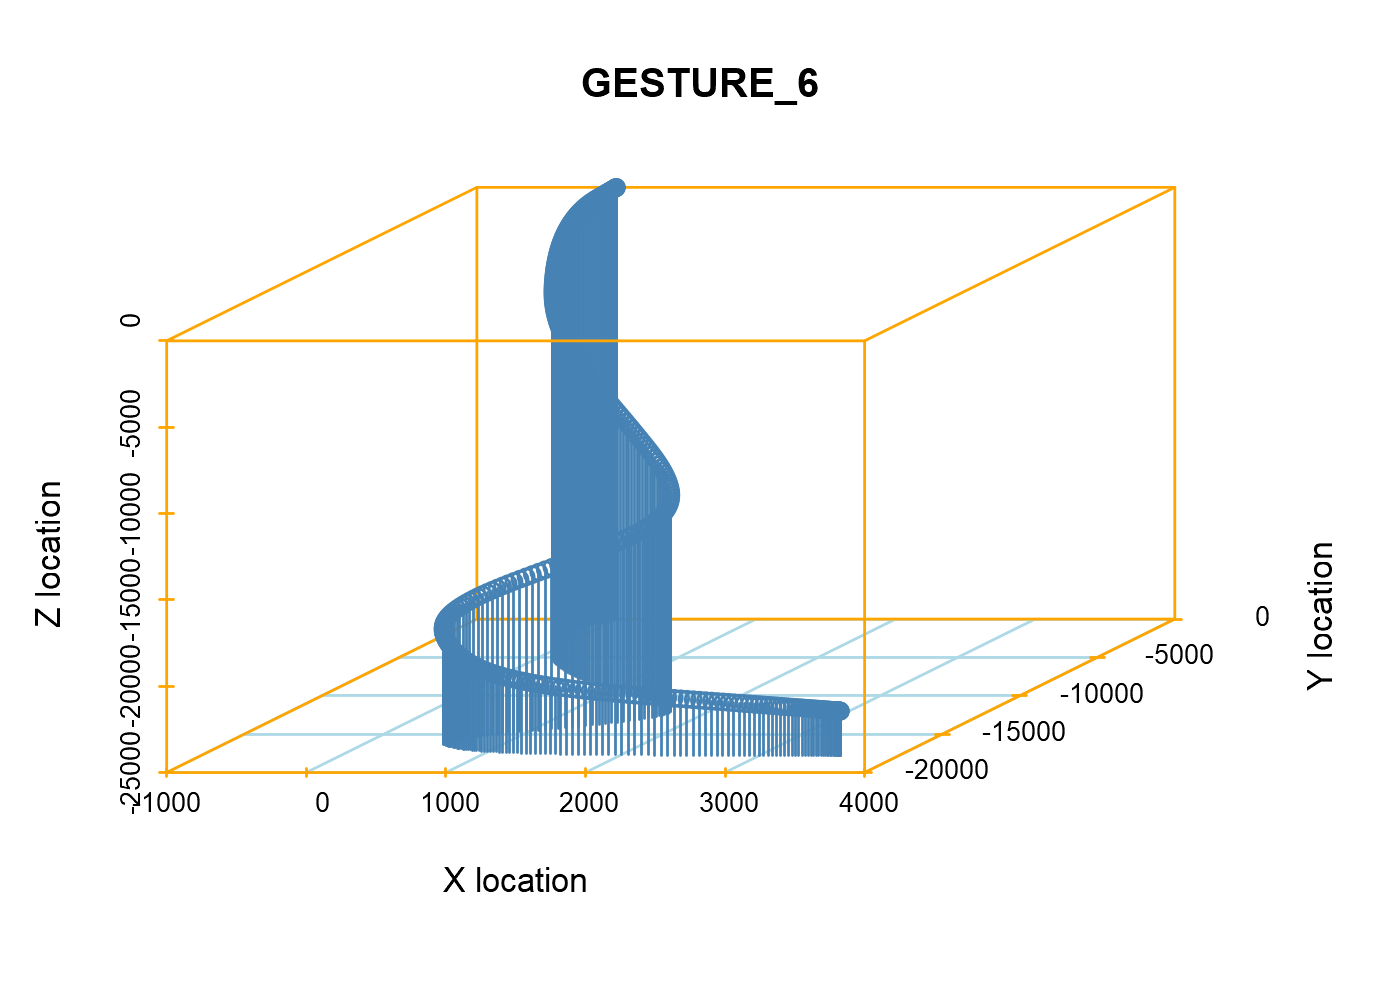

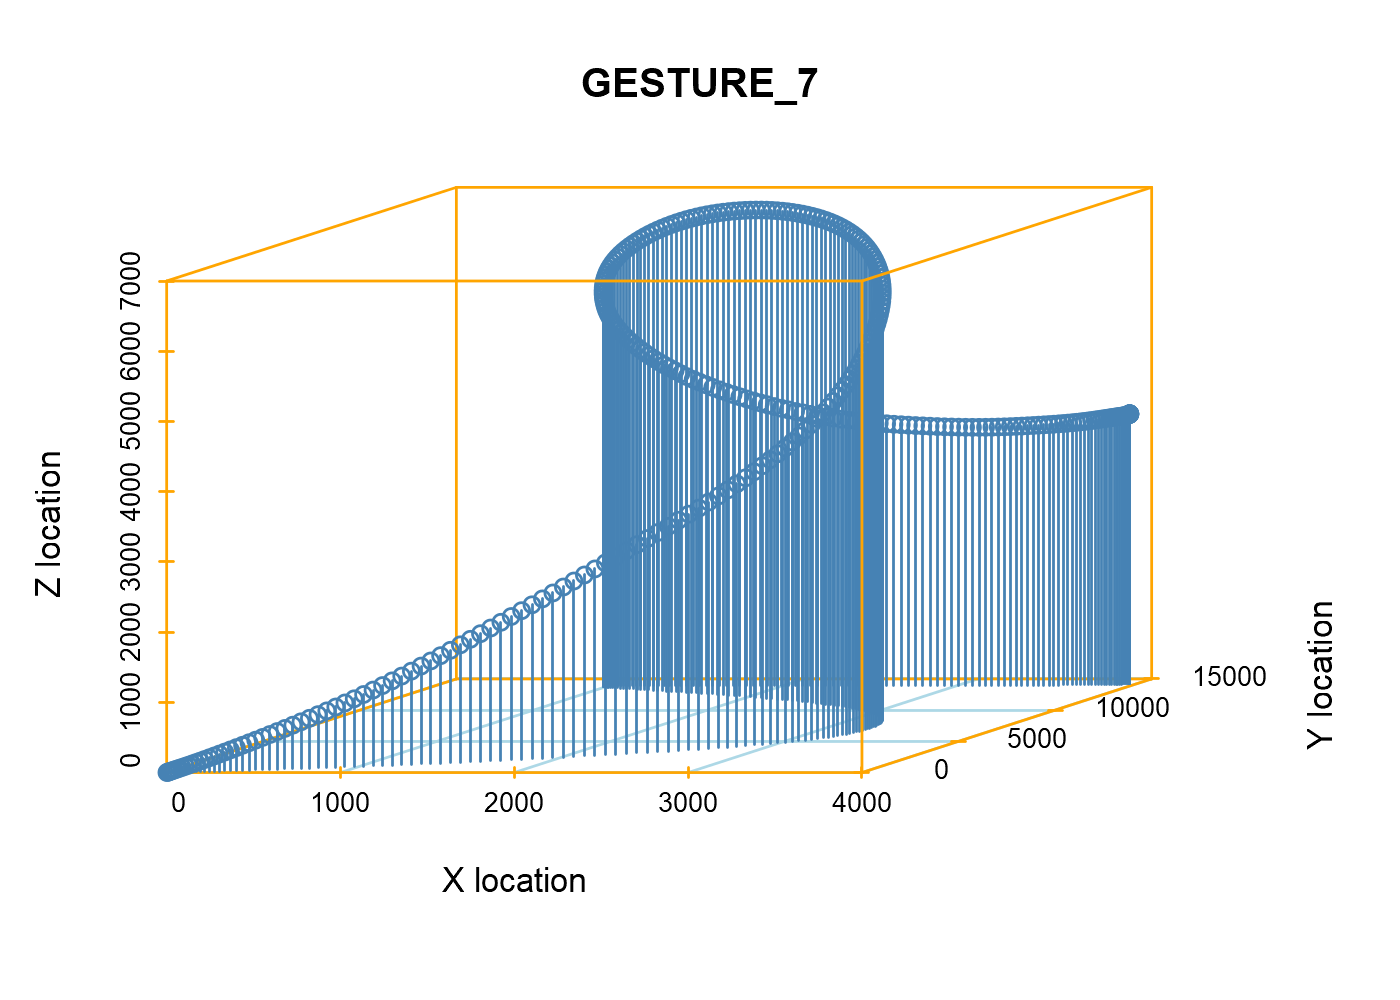

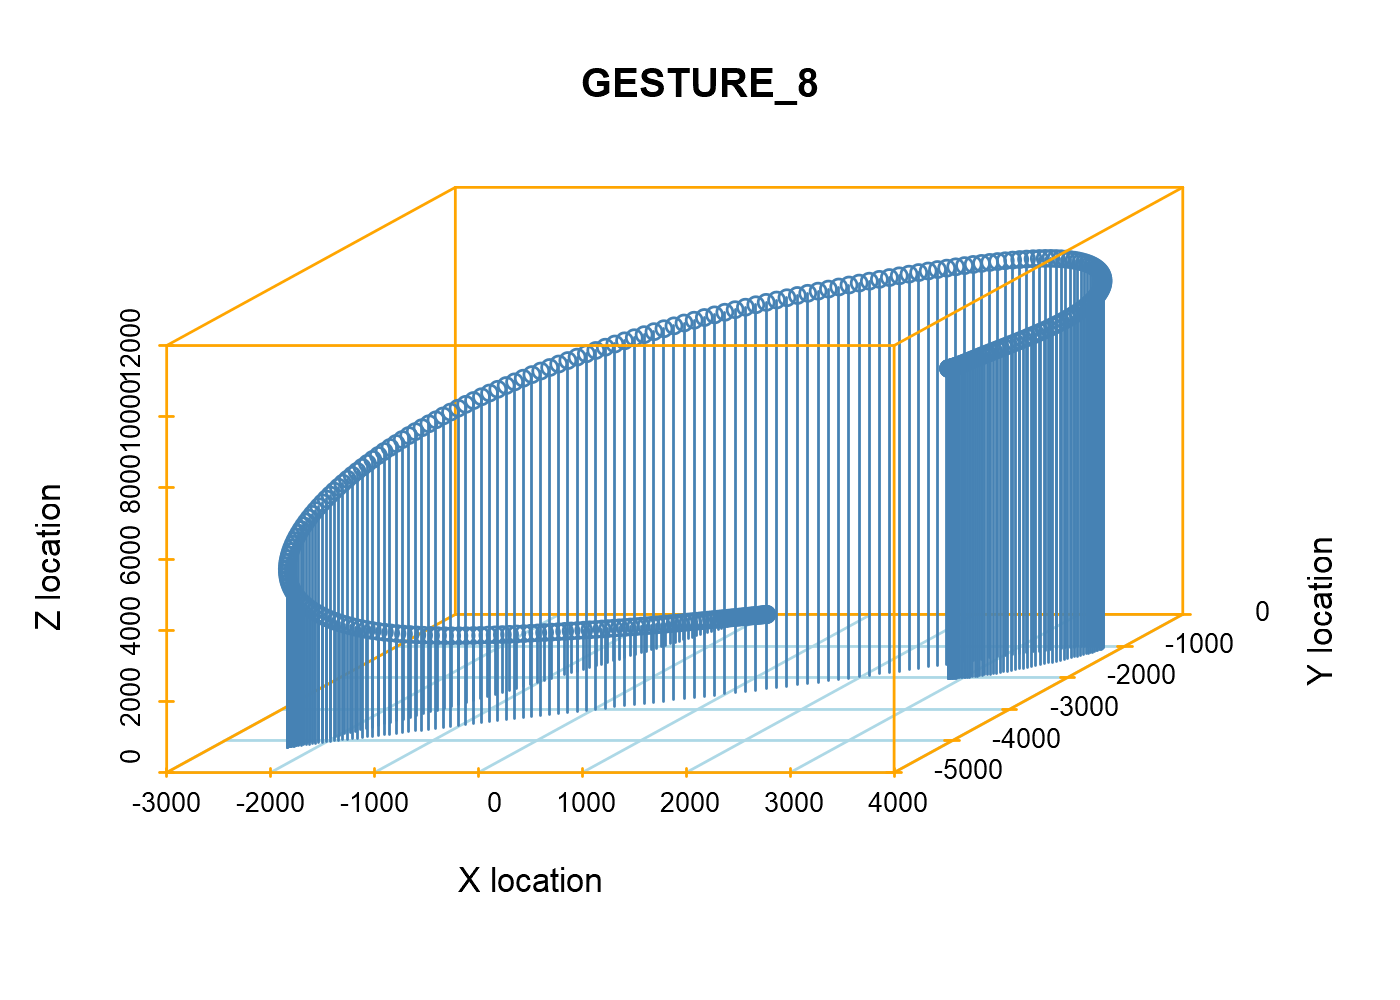

In [3]:
# consider gestures listed below 
x_loc_train[,.(idx_ref = max(idx)),.(V1)][order(V1)]
idx_ref = x_loc_train[,.(idx_ref = min(idx)),.(V1)][order(V1)]$idx_ref

x_loc_molten = melt(x_loc_train[idx %in% idx_ref], id.vars=c("idx","V1"))
y_loc_molten = melt(y_loc_train[idx %in% idx_ref], id.vars=c("idx","V1"))
z_loc_molten = melt(z_loc_train[idx %in% idx_ref], id.vars=c("idx","V1"))

setnames(x_loc_molten,"value","x")
setnames(y_loc_molten,"value","y")
setnames(z_loc_molten,"value","z")

data = merge(x_loc_molten,y_loc_molten, by = c("idx","V1","variable"), all.x = TRUE)
data = merge(data,z_loc_molten, by = c("idx","V1","variable"), all.x = TRUE)

data$V1 = as.factor(data$V1)

library(scatterplot3d)
max_x <- max(data$x)
min_x <- min(data$x)
max_y <- max(data$y)
min_y <- min(data$y)
max_z <- max(data$z)
min_z <- min(data$z)


for( i in idx_ref){
    focus_dt = data[idx == i] 
    gesture = unique(focus_dt$V1)
    
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 200)
par(mfrow=c(1,1))
scatterplot3d(focus_dt[,.(x,y,z)],col.axis="orange"
                  ,main = paste0("GESTURE_",gesture)
                  ,xlab = "X location"
                  ,ylab = "Y location"
                  ,zlab = "Z location"
                  ,col.grid="lightblue"
                  ,type = "h"
                  ,color = "steelblue"
           #   ,xlim=c(min_x,max_x)
           #   ,ylim=c(min_y,max_y)
           #   ,zlim=c(min_z,max_z)
             )
}


In [4]:
colnames(x_train) <- paste("x", colnames(x_train), sep = "_")
colnames(y_train) <- paste("y", colnames(y_train), sep = "_")
colnames(z_train) <- paste("z", colnames(z_train), sep = "_")
setnames(x_train,c("x_V1","x_idx"),c("class","idx"))
setnames(y_train,c("y_V1","y_idx"),c("class","idx"))
setnames(z_train,c("z_V1","z_idx"),c("class","idx"))

dt_train = merge(x_train,y_train, by = c("class","idx"), all = TRUE)
dt_train = merge(dt_train,z_train, by = c("class","idx"), all = TRUE)

colnames(x_test) <- paste("x", colnames(x_test), sep = "_")
colnames(y_test) <- paste("y", colnames(y_test), sep = "_")
colnames(z_test) <- paste("z", colnames(z_test), sep = "_")
setnames(x_test,c("x_V1","x_idx"),c("class","idx"))
setnames(y_test,c("y_V1","y_idx"),c("class","idx"))
setnames(z_test,c("z_V1","z_idx"),c("class","idx"))

dt_test = merge(x_test,y_test, by = c("class","idx"), all = TRUE)
dt_test = merge(dt_test,z_test, by = c("class","idx"), all = TRUE)

head(dt_train)
head(dt_test)

class,idx,x_V2,x_V3,x_V4,x_V5,x_V6,x_V7,x_V8,x_V9,...,z_V307,z_V308,z_V309,z_V310,z_V311,z_V312,z_V313,z_V314,z_V315,z_V316
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,11,-0.7914472,-0.7914472,-0.7958727,-0.8100650,-0.8492300,-0.9034648,-0.9311463,-0.9506034,...,-0.007064043,0.005635896,0.005635896,0.005635896,0.005635896,0.005635896,0.005635896,0.005635896,0.0056358959,0.005635896
1,17,-0.4496024,-0.4496024,-0.4496024,-0.4496024,-0.4496024,-0.4496024,-0.4496024,-0.4496024,...,0.818898610,0.836255730,0.843713110,0.843713110,0.865129740,0.894523900,0.928200950,0.961877850,0.9955547400,1.029231600
1,19,-0.1874689,-0.1874689,-0.1874689,-0.1874689,-0.1874689,-0.1874689,-0.1874689,-0.1874689,...,0.251094240,0.272352210,0.285509200,0.298452750,0.310528340,0.321015040,0.321015040,0.321015040,0.3210150400,0.321015040
1,23,0.3014817,0.3014817,0.3014817,0.3014817,0.3014817,0.3014817,0.3014817,0.3014817,...,0.046817682,0.046817682,0.046817682,0.046142200,0.042719759,0.038071443,0.025332352,0.012593260,-0.0001458324,-0.012884924
1,38,0.1632022,0.1632022,0.1632022,0.1632022,0.1632022,0.1632022,0.1632022,0.1632022,...,0.684985310,0.678932910,0.657091280,0.610350060,0.563609010,0.516867900,0.470126680,0.423385450,0.3766442300,0.329903000
1,43,-0.9319900,-0.9319900,-0.9319900,-0.9319900,-0.9319900,-0.9319900,-0.9319900,-0.9319900,...,-0.123477210,-0.159502030,-0.210131480,-0.273817140,-0.326935460,-0.364647520,-0.396490350,-0.428333180,-0.4601760300,-0.492018850


class,idx,x_V2,x_V3,x_V4,x_V5,x_V6,x_V7,x_V8,x_V9,...,z_V307,z_V308,z_V309,z_V310,z_V311,z_V312,z_V313,z_V314,z_V315,z_V316
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,-0.07509626,-0.07509626,-0.07509626,-0.07509626,-0.07509626,-0.07509626,-0.07509626,-0.07509626,...,0.9613500,0.8491418,0.7255457,0.5892767,0.5390750,0.5158101,0.5158101,0.5158101,0.5158101,0.51581006
1,10,-0.01763166,-0.01763166,-0.01763166,-0.01763166,-0.01763166,-0.01763166,-0.01763166,-0.01763166,...,2.1875377,2.1377916,2.0880455,2.0382994,1.9889839,1.9459109,1.9096874,1.8848143,1.8599413,1.83506830
1,16,-1.45837260,-1.45837260,-1.45837260,-1.45837260,-1.45837260,-1.45837260,-1.45837260,-1.45837260,...,0.2931751,0.2766158,0.2766158,0.2766158,0.2766158,0.2766158,0.2766158,0.2766158,0.2766158,0.27661584
1,27,-1.07409640,-1.07409640,-1.07409640,-1.07409640,-1.07409640,-1.07409640,-1.07409640,-1.07409640,...,0.2936187,0.2936187,0.2935540,0.2913842,0.2892145,0.2768035,0.2597172,0.2426309,0.2255445,0.20845812
1,40,-0.30599214,-0.30599214,-0.30599214,-0.30599214,-0.30599214,-0.30599214,-0.30599214,-0.30599214,...,0.6753049,0.6378932,0.6039074,0.5225977,0.4305530,0.3561305,0.2918744,0.2295368,0.1671992,0.10486166
1,47,-0.57313375,-0.57313375,-0.57313375,-0.57313375,-0.57313375,-0.57313375,-0.57313375,-0.57313375,...,0.5078625,0.5579469,0.5869332,0.5984730,0.5890882,0.5149175,0.4187813,0.2940630,0.1484793,-0.00177349


In [5]:
rm(x_train,y_train,z_train,x_test,y_test,z_test)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2291628,122.4,3765615,201.2,3765615,201.2
Vcells,12816919,97.8,21346748,162.9,19836433,151.4


In [6]:
unique(dt_train$class)
unique(dt_test$class)

[1] 1 2 3 4 5 6 7 8

[1] 1 2 3 4 5 6 7 8

In [7]:
nrow(dt_train)
nrow(dt_test)

[1] 896

[1] 3582

## KNN

In [8]:
dt_train[,c("idx") := NULL]
dt_test[,c("idx") := NULL]

dt_train$class = as.factor(dt_train$class)
dt_test$class = as.factor(dt_test$class)

### Finding ideal k

In [9]:
#define accuracy function
find_accuracy = function(m){
    summ = 0
    for(i in c(1:nrow(m))){
        summ = summ + m[i,i] 
    }
return(summ/ sum(m))
}

In [10]:
set.seed(47674)
knn_perf_table = data.table()
k_list = c(1,5,10,15,20,25,30)
for (k in k_list){ 
    print(k)
    fit.kknn.1 = cv.kknn(class~., dt_train, kcv = 10, distance = 1,kernel = "rectangular" , k = k)
    fit.kknn.2 = cv.kknn(class~., dt_train, kcv = 10, distance = 2,kernel = "rectangular" , k = k)
    
    pred.1 = fit.kknn.1[[1]]
    error.1 = fit.kknn.1[[2]]
    pred.2 = fit.kknn.2[[1]]
    error.2 = fit.kknn.2[[2]]

    knn_perf_table= rbind(knn_perf_table, data.table("k" = k,"dist" = 1 ,"error" = error.1))
    knn_perf_table= rbind(knn_perf_table, data.table("k" = k,"dist" = 2 ,"error" = error.2))
}

[1] 1
[1] 5
[1] 10
[1] 15
[1] 20
[1] 25
[1] 30


In [11]:
#min error for both dist = 1 and dist = 2 is reached when
best_k.1 = knn_perf_table[dist == 1][which.min(knn_perf_table[dist == 1]$error),]$k
best_k.2 = knn_perf_table[dist == 2][which.min(knn_perf_table[dist == 2]$error),]$k

best_k.1
best_k.2

[1] 1

[1] 5

### Predictions by KNN

In [12]:
start.time <- Sys.time()
fit.kknn.1 = kknn(class~., dt_train, dt_test, distance = 1,kernel = "rectangular" , k = best_k.1)
end.time <- Sys.time()
time.taken.1 <- end.time - start.time

fit.kknn.2 = kknn(class~., dt_train, dt_test, distance = 2,kernel = "rectangular" , k = best_k.2)
end.time <- Sys.time()
time.taken.2 <- end.time - start.time - time.taken.1

In [13]:
pred.kknn.1 = fit.kknn.1$fitted.values
pred.kknn.2 = fit.kknn.2$fitted.values

In [14]:
cm.1 = table(dt_test$class, pred.kknn.1)
cm.2 = table(dt_test$class, pred.kknn.2)

print("x_axis --> actual")
print("y_axis --> predicted")
print("---------------------")

print("time taken for knn dist = 1")
time.taken.1
print("confusion matrix for knn with dist = 1")
cm.1
print("accuracy for knn with dist = 1")
find_accuracy(cm.1)

print("time taken for knn dist = 2")
time.taken.2
print("confusion matrix for knn with dist = 2")
cm.2
print("accuracy for knn with dist = 2")
find_accuracy(cm.2)

[1] "x_axis --> actual"
[1] "y_axis --> predicted"
[1] "---------------------"
[1] "time taken for knn dist = 1"


Time difference of 50.46667 secs

[1] "confusion matrix for knn with dist = 1"


   pred.kknn.1
      1   2   3   4   5   6   7   8
  1 432   0   0   1   0   4   0   0
  2   1 451   0   0   0   0   0   0
  3   2   0 417   0  16  14   5   0
  4   3   0   0 395  41   8   0   3
  5   3   0   9   4 416   1   0   0
  6   3   0   6  12  15 412   0   1
  7   0   0   3   0   0   0 444   0
  8   0   0   0   3   1   0   0 456

[1] "accuracy for knn with dist = 1"


[1] 0.9556114

[1] "time taken for knn dist = 2"


Time difference of 8.044984 secs

[1] "confusion matrix for knn with dist = 2"


   pred.kknn.2
      1   2   3   4   5   6   7   8
  1 429   0   0   3   0   5   0   0
  2   1 449   0   0   0   0   1   1
  3   0   0 411   0  18  19   6   0
  4   4   0   0 363  67   9   0   7
  5   3   0   5   1 423   1   0   0
  6   5   0   5  16  32 391   0   0
  7   0   0   3   0   0   0 444   0
  8   0   0   0   1   1   0   0 458

[1] "accuracy for knn with dist = 2"


[1] 0.9402568

### weighted distance?

knn generally considers unweighted distance between observations. However, there are weighted versions of knn as formulated in kknn package. 

I think that depending on the problem weighting distances can make more sense. For instance, in our problem, some gestures are very similar such as gesture 4 and gesture 5. They follow different directions in z axis. Therefore, putting more weight on the distance between gesture 4 and 5 on z_axis compared to other axes can be applied to highlight the difference between these two gestures. 

Below, I fit a 5-nn model with weighted distances using kernel = "epanechnikov". This model considers euclidean distance between observations.

When unweighted 5-nn with euclidean distance achieves rougly 94.2% accuracy, weighted version performs slightly better with 94.7% accuracy. So, this example shows that weighted knn may perform better than unweighted version.

In [15]:
start.time <- Sys.time()
fit.kknn.1.w = kknn(class~., dt_train, dt_test, distance = 2,kernel = "epanechnikov" , k = 5)
end.time <- Sys.time()
time.taken.1.w <- end.time - start.time
time.taken.1.w

Time difference of 7.940929 secs

In [16]:
## weights
#head(fit.kknn.1.w$W)
## distances
#head(fit.kknn.1.w$D)

In [17]:
pred.kknn.1.w = fit.kknn.1.w$fitted.values
cm.1.w = table(dt_test$class, pred.kknn.1.w)
cm.1.w
print(paste0("accuracy: ",find_accuracy(cm.1.w)))
#previously on
print(paste0("previously, accuracy: ", 1-knn_perf_table[dist == 2 & k == 5]$error))

   pred.kknn.1.w
      1   2   3   4   5   6   7   8
  1 431   0   0   2   0   4   0   0
  2   1 450   0   0   0   0   1   0
  3   1   0 414   0  16  19   4   0
  4   5   0   0 375  56   7   0   7
  5   3   0   8   2 418   2   0   0
  6   5   0   3  13  23 404   1   0
  7   0   0   3   0   0   0 444   0
  8   0   0   0   1   1   0   0 458

[1] "accuracy: 0.94751535455053"
[1] "previously, accuracy: 0.940848214285714"


## Logistic Regression

In [18]:
dt_train[, class3 := ifelse(class == 3, 1,0)]
dt_test[, class3 := ifelse(class == 3, 1,0)]

freq_3 = nrow(dt_train[class3 == 1]) / nrow(dt_train)
print("distribution of class 3 in whole training data set")
freq_3

#
x_test = dt_test[,.SD,.SDcols = -c("class","class3")]
x_train = dt_train[,.SD,.SDcols = -c("class","class3")]

y_test = dt_test$class3
y_train = dt_train$class3

[1] "distribution of class 3 in whole training data set"


[1] 0.1183036

### Training Logit Model

In [19]:
fit.lr <- glmnet(x = as.matrix(x_train),
                 y = y_train, 
            family=binomial)
pred.lr <- predict(fit.lr, newx = as.matrix(x_test), type = "response", s = c(0))
pred.lr = ifelse(pred.lr >= freq_3,1,0  )

cm.lr <- table(y_test, pred.lr)
cm.lr

print(paste0("accuracy: ",find_accuracy(cm.lr)))

      pred.lr
y_test    0    1
     0 2901  227
     1   49  405

[1] "accuracy: 0.922948073701843"


### Interpretability

In [20]:
start.time <- Sys.time()
cv.fit.lr <- cv.glmnet(x = as.matrix(x_train),
                       y = y_train, 
                       family=binomial,
                       type.measure  = "deviance",
                       nfolds = 10)
end.time <- Sys.time()
time.taken.cv <- end.time - start.time
print(paste0("runtime: ",time.taken.cv))

[1] "runtime: 2.04456146558126"


[1] 0.003889571

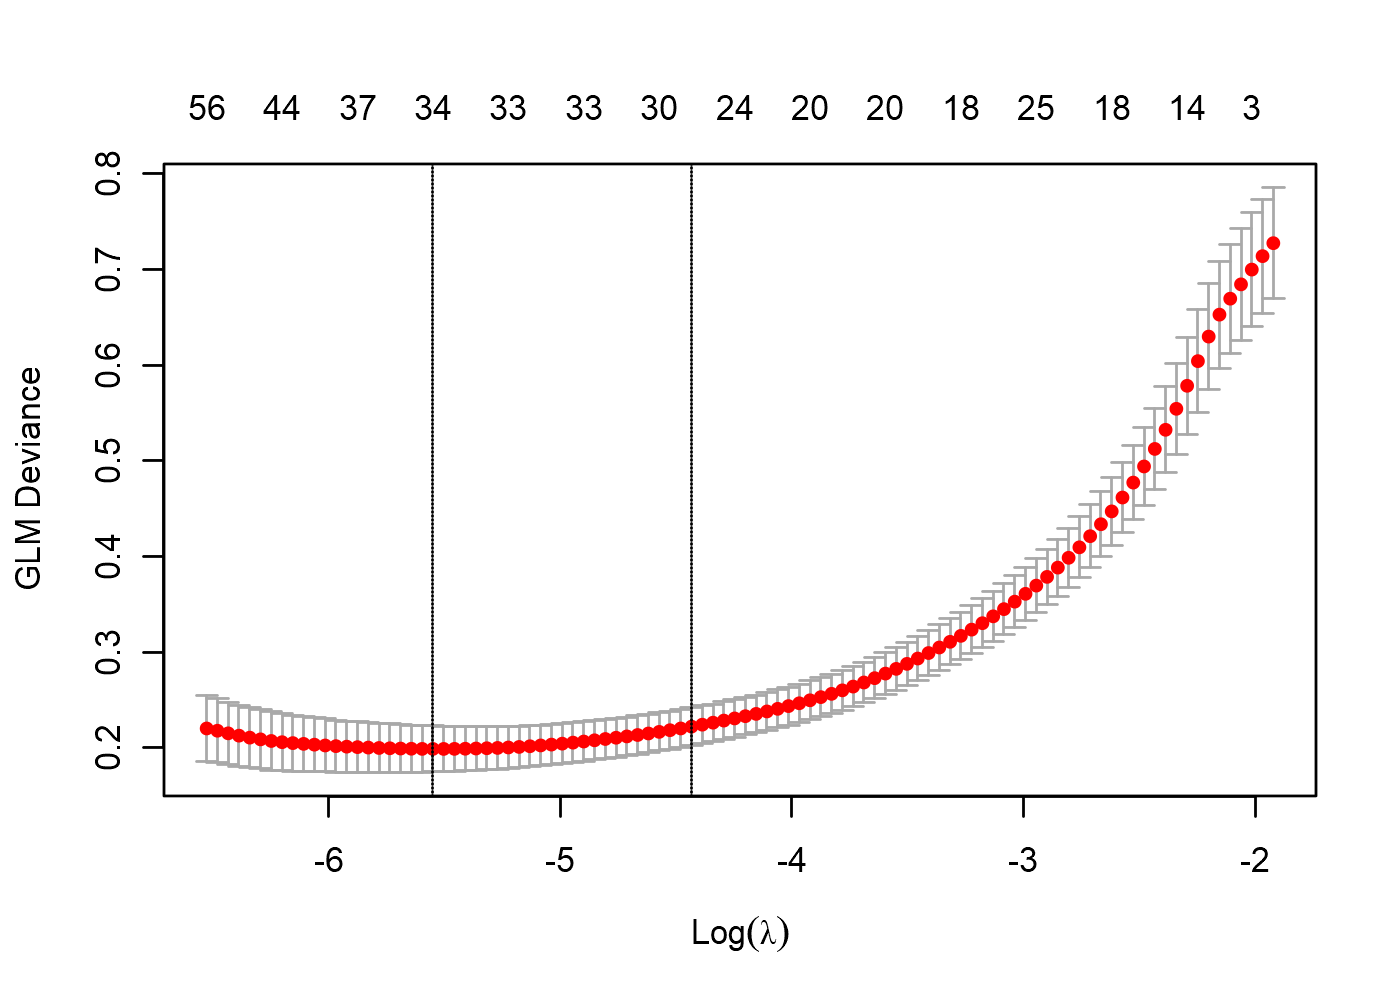

In [21]:
plot(cv.fit.lr)
#best lambda
lambda_best = cv.fit.lr$lambda.min
lambda_best

In [22]:
#type = response gives probabilities
cv.pred.lr <- predict(cv.fit.lr, newx = as.matrix(x_test), type = "response", s = lambda_best)
cv.pred.lr = ifelse(cv.pred.lr >= freq_3,1,0  )

cv.cm.lr <- table(y_test, cv.pred.lr)
cv.cm.lr

print(paste0("previous accuracy: ",find_accuracy(cm.lr)))
print(paste0("now, accuracy: ",find_accuracy(cv.cm.lr)))
print(paste0("runtime: ",time.taken.cv))

      cv.pred.lr
y_test    0    1
     0 2879  249
     1   31  423

[1] "previous accuracy: 0.922948073701843"
[1] "now, accuracy: 0.921831379117811"
[1] "runtime: 2.04456146558126"


**Comment**

Accuracy has sligthy decreased after elimination of a large number of features. Yet, I think that sacrificing from 0.002 of accuracy to obtrain a more interpretable model is completely ok. Now, we can understand the factors related to being gesture 3 better. 

In [23]:
##importance of features
imp = t(t(cv.fit.lr$glmnet.fit$beta[,which(cv.fit.lr$glmnet.fit$lambda == lambda_best)]))
row_names = rownames(imp)
imp = data.table(features= row_names, "score" = imp)
imp = imp[score.V1 != 0]
imp$axis = substr(imp$features,1,1)
imp$time = as.numeric(substr(imp$features,4,10))

imp
imp[,.N,.(axis)]
summaries = imp[, as.list(summary(time)), by = axis]
summaries

features,score.V1,axis,time
<chr>,<dbl>,<chr>,<dbl>
x_V18,-0.0008287581,x,18
x_V20,-0.1012389974,x,20
x_V34,-0.0028972869,x,34
x_V44,-0.2350425859,x,44
x_V45,-0.2230091026,x,45
x_V51,-0.0302853424,x,51
x_V89,-0.2512314665,x,89
x_V145,-0.0542430322,x,145
x_V211,0.1202897781,x,211


axis,N
<chr>,<int>
x,22
y,7
z,5


axis,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
x,18,60.5,236.5,189.2273,286,316
y,13,17.0,161.0,113.5714,180,227
z,89,100.0,181.0,164.0000,192,258


**Tables above imply that:**

* 22 features belonging to x_axis have an effect on class prediction. On the other hand, only a few features of y and z axes seem to have impact on the target.

* The finding above can be validated by looking at an example graph of gesture 3. It cen be easily seen that the variability in the gesture 3 is the highest on x_axis (generally covers 15000 units of a range, ref. above graph and figure 1. in homework).

* Moreover, summary table is consistent as well. difference between the min and max values of x_axis features are higher than the differences in the other axes. 

### Nonlinearity

In [24]:
x_test = dt_test[,.SD,.SDcols = -c("class","class3")]
x_train = dt_train[,.SD,.SDcols = -c("class","class3")]

train_dist = flexclust::dist2(x_train, x_train, method = "euclidean", p=2)
test_dist = flexclust::dist2(x_test, x_train, method = "euclidean", p=2)

Time difference of 1.449988 mins

[1] 0.002229629

      cv.pred.lr2
y_test    0    1
     0 3005  123
     1   18  436

[1] "previous accuracy: 0.921831379117811"
[1] "now, accuracy: 0.960636515912898"
[1] "runtime: 1.44998803536097"


[1] 36


 1  2  3  4  5  6  7  8 
 0  0 25  1  3  5  2  0 

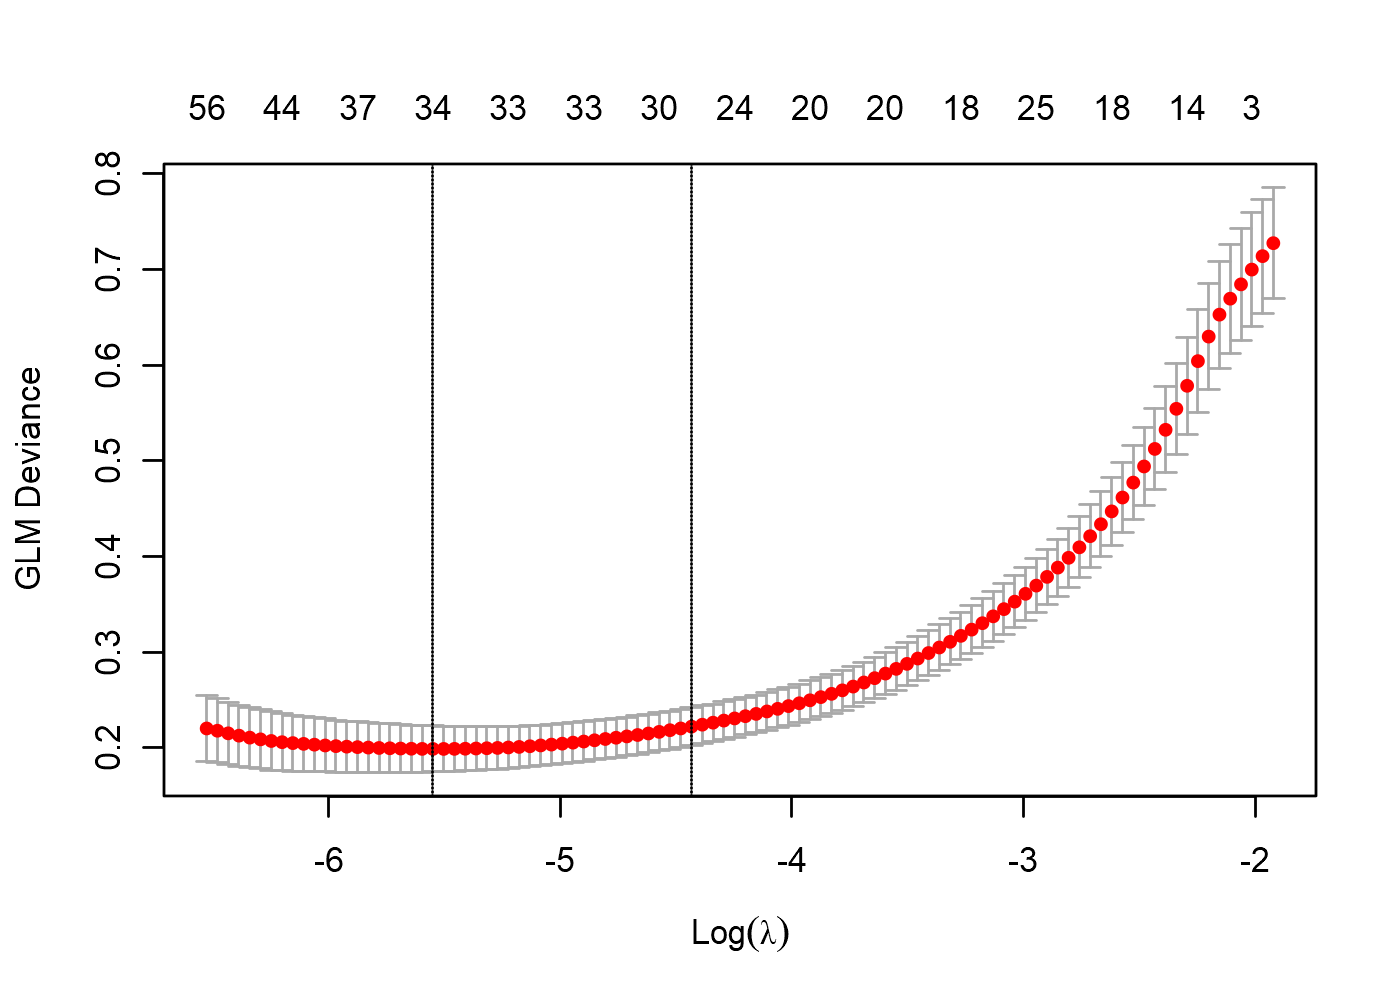

In [28]:
start.time <- Sys.time()
cv.fit.lr2 <- cv.glmnet(x = train_dist,
                       y = y_train, 
                       family=binomial,
                       type.measure  = "deviance",
                       nfolds = 10)
end.time <- Sys.time()
time.taken.cv2 <- end.time - start.time
time.taken.cv2

plot(cv.fit.lr)
#best lambda
lambda_best2 = cv.fit.lr2$lambda.min
lambda_best2

#type = response gives probabilities
cv.pred.lr2 <- predict(cv.fit.lr2, newx = as.matrix(test_dist), type = "response", s = lambda_best2)
cv.pred.lr2 = ifelse(cv.pred.lr2 >= freq_3,1,0  )

cv.cm.lr2 <- table(y_test, cv.pred.lr2)
cv.cm.lr2

print(paste0("previous accuracy: ",find_accuracy(cv.cm.lr)))
print(paste0("now, accuracy: ",find_accuracy(cv.cm.lr2)))
print(paste0("runtime: ",time.taken.cv2))

##importance of features
imp2 = t(t(cv.fit.lr2$glmnet.fit$beta[,which(cv.fit.lr2$glmnet.fit$lambda == lambda_best2)]))
imp2 = data.table(features= rownames(imp2), "score" = imp2)
imp2 = imp2[score.V1 != 0]
imp2$num = as.numeric(substr(imp2$features,2,10))

nrow(imp2)
table(dt_train[imp2$num,]$class)

Now, coefficients do not correspond to axes features, but observations in training data set. We can observe that 36 data points in the training set have an impact on deciding on gesture 3 in the test set. If we check these data points in the training set, we can easily see that these data points are generally of gesture 3 (25, almost 70%).   

### Comparisons

#### Logit Model

In [ ]:
#logit
cm.lr
print(paste0("accuracy: ",find_accuracy(cm.lr)))

#### Logit Model with lambda

In [ ]:
cv.cm.lr
print(paste0("accuracy: ",find_accuracy(cv.cm.lr)))
print(paste0("runtime: ",time.taken.cv, "  mins"))


**Comparison between Logit Model and Logit Model with lambda**

By introducing lambda and shrinking the number of features, we could obtain a ore interpretable logit model. Moreover, elimination of features did not cost us a lot in terms of accuracy. Only, 0.2% of accuracy is lost. Indeed, if we focus on confusion matrix, with an ideal lambda, the logit model can predict class 3 gestures better than the initial model ( increasing from 405 to 423). 

The only drawback is the run time. The initial model can run in an instant but we need almost 3 minutes for the logit model with lambda.

#### Logit model with distances

In [ ]:
cv.cm.lr2
print(paste0("accuracy: ",find_accuracy(cv.cm.lr2)))
print(paste0("runtime: ",time.taken.cv2, "  mins"))

**Comparison between Logit Model with lambda and Logit Model with distances**
Using distance matrices improves the prediction power of logistic regression model. Both accuracy and confusion matrix improves. The results are very satisfying. Also, runtime decreases almost 31%.

**As a result**,

It seems that nonlinearity in the gesture 3's acceleration can be best captured if distance between the test observations and training observations. 